## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')

b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

In [4]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df[df['converted']==1].count()[0]/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
line1=df.query('landing_page=="new_page" and group=="control"').count()[0]
line2=df.query('landing_page=="old_page" and group=="treatment"').count()[0]
line1+line2

3893

In [8]:
df.groupby(['landing_page', 'group']).count()

user_id  timestamp  converted
landing_page group                                   
new_page     control       1928       1928       1928
             treatment   145311     145311     145311
old_page     control     145274     145274     145274
             treatment     1965       1965       1965

f. Do any of the rows have missing values?

In [9]:
df.isnull().values.any()

False

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
i=df.query('landing_page=="new_page" and group=="control" or landing_page=="old_page" and group=="treatment"').index
df2=df.drop(i)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2.user_id.duplicated()==True].index

Int64Index([2893], dtype='int64')

c. What is the row information for the repeat **user_id**? 

In [14]:
df2.loc[2893]

user_id                             773192
timestamp       2017-01-14 02:55:59.590927
group                            treatment
landing_page                      new_page
converted                                0
Name: 2893, dtype: object

In [15]:
df2.shape

(290585, 5)

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2=df2.drop(df.index[2893], axis=0)
df2.shape

(290584, 5)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
df2[df2['landing_page']== 'new_page'].count()[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

There are no sufficient evidence that the new treatment page led to more conversions as we obtain nearly the same probability for conversion in general or by group. Furthermore additional factors could interfere with the result but we do not know yet such as the age or the country of residence. Besides, we do not also have any confidence interval for these numbers. So neither we can say if there is any practical or statistical significance in the decion making.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$ H0= Pnew-Pold<=0$$
$$H1= Pnew-Pold >0$$
We will check if the p_value is above or lower than 0.05 (corresponding to Type I error of 5%). We can decide then if H0 is rejected (p<0.05) or not.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
df2['converted'].mean()

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
mean2=df2['converted'].mean()
mean2

0.11959708724499628

c. What is $n_{new}$?

In [23]:
df2[df2['group']=="treatment"].count()[0]

145310

d. What is $n_{old}$?

In [24]:
df2[df2['group']=="control"].count()[0]

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted=np.random.choice([0,1],size=145310, p=[mean2, 1-mean2])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted=np.random.choice([0,1],size=145274, p=[mean2, 1-mean2])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
diff_p= new_page_converted.mean()-old_page_converted.mean()
diff_p

0.0002502453255645021

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
diffs=[]
for _ in range(10000):
    new_page_converted=np.random.choice([0,1],size=145310, p=[mean2, 1-mean2])
    old_page_converted=np.random.choice([0,1],size=145274, p=[mean2, 1-mean2])
    newdiff=new_page_converted.mean()-old_page_converted.mean()
    diffs.append(newdiff)
p_diffs=np.array(diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([7.000e+00, 5.000e+01, 4.500e+02, 1.874e+03, 3.392e+03, 2.864e+03,
        1.123e+03, 2.230e+02, 1.600e+01, 1.000e+00]),
 array([-0.00519423, -0.00410402, -0.00301381, -0.0019236 , -0.00083339,
         0.00025682,  0.00134703,  0.00243724,  0.00352745,  0.00461766,
         0.00570787]),
 <a list of 10 Patch objects>)

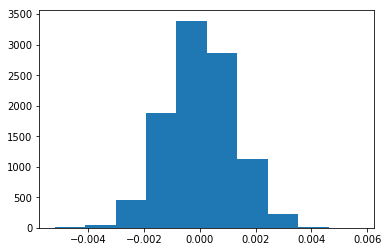

In [29]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
diff_actual=df2.query('group == "treatment"')['converted'].mean()-df2.query('group == "control"')['converted'].mean()
(p_diffs>diff_actual).mean()

0.9104

(array([7.000e+00, 5.000e+01, 4.500e+02, 1.874e+03, 3.392e+03, 2.864e+03,
        1.123e+03, 2.230e+02, 1.600e+01, 1.000e+00]),
 array([-0.00519423, -0.00410402, -0.00301381, -0.0019236 , -0.00083339,
         0.00025682,  0.00134703,  0.00243724,  0.00352745,  0.00461766,
         0.00570787]),
 <a list of 10 Patch objects>)

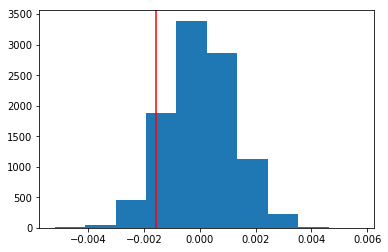

In [31]:
plt.axvline(diff_actual, c='red')
plt.hist(p_diffs)

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

In part j, we have shown the difference between the conversion rate of the population and the conversion rate from sampling distribution. We have calculated the p_value in order to decide if we can reject or not the null hypothesis. To reject $H0$, we should have a P-value below 0.05 for a confidence interval of 95%.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"and converted == 1').count()[0]
convert_new = df2.query('group == "treatment"and converted == 1').count()[0]
n_old = df2[df2['landing_page']=="old_page"].count()[0]
n_new = df2[df2['landing_page']=="new_page"].count()[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Since the z-score does not exceed the confidence interval of 95% (1.95 as per link above) and that the p_value is high, we fail to reject the null hypothesis being that the conversion rate of the new page is smaller than the conversion rate of the old page. The p_value is also the same at .90 with ztest or the simulation.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

As we have only one categorical explanatory variable we will perform a logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
import statsmodels.api as sm
df2['intercept']=1
df2[['aa_page','ab_page']]=pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,aa_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [35]:
dff=df2.drop('aa_page', axis=1)

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
lm=sm.OLS(dff['user_id'], dff[['intercept','ab_page']])


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
result=lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                user_id   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8847
Date:                Tue, 12 Jun 2018   Prob (F-statistic):              0.347
Time:                        14:31:13   Log-Likelihood:            -3.7311e+06
No. Observations:              290584   AIC:                         7.462e+06
Df Residuals:                  290582   BIC:                         7.462e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.882e+05    239.342   3293.047      0.000    7.88e+05    7.89e+05
ab_page     -318.3533    338.460     -0.941      0.347    -981.725     345.018
==============================================================================
Omnibus:                   258753.550   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17444.304
Skew:                           0.000   Prob(JB):                         0.00
Kurtosis:                       1.800   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p_value is 0.347 and it differs from the above result. Here the conclusion is that there is no evidence in relationship with the new page and users. Rsquared is also equal to 0 which means the model does not fit. Previously we had a null hypothesis as a conversion difference in mean for the new page and the old page. Here we are looking to predict whether or not an individual converts.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

There might be some biais as novelty, if there is sufficient traffic or simply if the time of the record was sufficiantly long. There is then good input to say that additional variables might correct such biais with a better view then on the efficiency of the new page. The cons are correlated errors, multicollinearity or outliers amongst others

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [39]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,aa_page,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [40]:
### Create the necessary dummy variables
df_new[['CA','UK','US']]=pd.get_dummies(df_new['country'])
df_new.reset_index(inplace=True)
df_new.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,aa_page,ab_page,CA,UK,US
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [41]:
df_new.query('group == "treatment" and country =="UK"')['converted'].mean()


0.1211709965102753

In [42]:
df_new.query('group == "treatment" and country =="US"')['converted'].mean()

0.11846559963887227

In [43]:
df_new.query('group == "treatment" and country =="CA"')['converted'].mean()

0.11190247911245035

In [44]:
df4=df_new.drop(['CA','aa_page'], axis=1)
df4['intercept']=1
lmm=sm.OLS(df4['ab_page'],df4[['intercept','UK','US']])
result1=lmm.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ab_page   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8946
Date:                Tue, 12 Jun 2018   Prob (F-statistic):              0.409
Time:                        14:31:13   Log-Likelihood:            -2.1090e+05
No. Observations:              290584   AIC:                         4.218e+05
Df Residuals:                  290581   BIC:                         4.218e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5036      0.004    121.267      0.000       0.495       0.512
UK            -0.0053      0.005     -1.166      0.244      -0.014       0.004
US            -0.0031      0.004     -0.720      0.472      -0.012       0.005
==============================================================================
Omnibus:                        0.003   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.999   Jarque-Bera (JB):            48429.474
Skew:                          -0.000   Prob(JB):                         0.00
Kurtosis:                       1.000   Cond. No.                         9.94
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
np.exp(result1.params)

intercept    1.654588
UK           0.994710
US           0.996912
dtype: float64

It does not seem that a change happened in terms of conversion. It is roughly the same as part I.According to the p_value we obtain from the summary, we can say that they have no impact or relationship between country and the new page conversion.
Furthermore we can say that for each 1 unit increase in people from UK , conversion rate is .99 times likely to happen holding all else constant. It is the same for US people. This seems to be odd compared to previous result.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
### Fit Your Linear Model And Obtain the Results
df5=df_new.drop(['CA','aa_page'], axis=1)
df5['UK_ab_page']=df5['UK']*df5['ab_page']
df5['US_ab_page']=df5['US']*df5['ab_page']
df5['intercept']=1
lmm=sm.OLS(df5['ab_page'],df5[['intercept','UK','US','UK_ab_page','US_ab_page']])
result2=lmm.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ab_page   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                 1.383e+06
Date:                Tue, 12 Jun 2018   Prob (F-statistic):               0.00
Time:                        14:31:14   Log-Likelihood:             2.2466e+05
No. Observations:              290584   AIC:                        -4.493e+05
Df Residuals:                  290579   BIC:                        -4.493e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5036      0.001    542.897      0.000       0.502       0.505
UK            -0.5036      0.001   -459.035      0.000      -0.506      -0.501
US            -0.5036      0.001   -507.903      0.000      -0.505      -0.502
UK_ab_page     1.0000      0.001   1205.143      0.000       0.998       1.002
US_ab_page     1.0000      0.000   2020.147      0.000       0.999       1.001
==============================================================================
Omnibus:                    66041.816   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3518151.415
Skew:                          -0.064   Prob(JB):                         0.00
Kurtosis:                      20.046   Cond. No.                         10.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
np.exp(result2.params)

intercept     1.654588
UK            0.604380
US            0.604380
UK_ab_page    2.718282
US_ab_page    2.718282
dtype: float64

It is difficult to state something about the coefficient related to country and page conversion. According to the Rsquared this model with higher order is better than the previous one to predict the conversion rate. We can say that for each 1 unit increase in people from UK , conversion rate is .60 times likely to happen holding all else constant. It is the same for US people.